# Theory Beakdown
This breaks down each contribution to the theoretical scaling factor.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms,mse_mod_anom_change_ft_expansion, mse_mod_change_surf_expansion, \
    get_scaling_factor_theory, get_temp_adiabat, decompose_temp_ft_anom_change, get_p_x
from isca_tools.thesis.adiabat_theory2 import decompose_var_x_change_integrate, decompose_var_x_change, get_scale_factor_theory
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [2]:
# Load dataset - at surface and in free troposphere
use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
# refer to bucket model with vegetation as bucket
# Don't include actual bucket, as looks very similar to bucket with vegetation param
# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'

# only keep variables required to compute relative humidity and MSE
if 'ras_conv' in exp_dir:
    var_keep = ['temp', 'sphum', 'height']
else:
    var_keep = ['temp', 'sphum', 'height']

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_kappa = len(kappa_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[var_keep]
        
        ds += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')]      # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        pbar.update(1)
        
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size
lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation

  0%|          | 0/2 [00:00<?, ?it/s]

## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

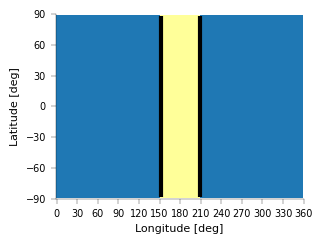

In [4]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land
    
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [5]:
# Load in across all latitudes, for given season

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]} 

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]

# Whether to do taylor expansion about mean over just land or mean over whole planet
mean_method = 'land'
# mean_method = 'all'

temp_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
sphum_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
r_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
z_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
mse_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
mse_ft_sat_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
epsilon_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
mse_mod_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
z_approx_error_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}

ds_all = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory
        
        if is_land_data:
            # if not aquaplanet, then is land and only consider land longitudes
            ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])
        
        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        
        if mean_method == 'all':
            ds_use = ds[j].sel(time=slice(use_time_start, np.inf)).isel(lat=lat_use_ind)
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        elif mean_method != 'land':
            raise ValueError(f'Mean method is {mean_method} which is not valid.')
        temp_av['mean'][j] = ds_use.temp.mean(dim='lon_time')
        z_av['mean'][j] = ds_use.height.mean(dim='lon_time')
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        r_av['mean'][j] = rh_use.mean(dim='lon_time')
        mse_use = [moist_static_energy(ds_use.temp[ind_surf], ds_use.sphum[ind_surf], ds_use.height[ind_surf]), 
                   moist_static_energy(ds_use.temp[ind_ft], sphum_sat(ds_use.temp[ind_ft], pressure_ft_actual), ds_use.height[ind_ft])]
        mse_av['mean'][j] = mse_use[0].mean(dim='lon_time')
        mse_ft_sat_av['mean'][j] = mse_use[1].mean(dim='lon_time')
        epsilon_use = mse_use[0] - mse_use[1]
        epsilon_av['mean'][j] = epsilon_use.mean(dim='lon_time')
        mse_mod_use = moist_static_energy(ds_use.temp.isel(pfull=ind_surf), ds_use.sphum.isel(pfull=ind_surf), height=0, c_p_const=c_p-lnp_const
                                          ) - epsilon_use
        mse_mod_av['mean'][j] = mse_mod_use.mean(dim='lon_time')

        mse_mod_use_ft_approx = moist_static_energy(ds_use.temp.isel(pfull=ind_ft), sphum_sat(ds_use.temp.isel(pfull=ind_ft), pressure_ft_actual),
                                                    height=0, c_p_const=c_p+lnp_const)
        z_error_use = mse_mod_use - mse_mod_use_ft_approx
        z_approx_error_av['mean'][j] = z_error_use.mean(dim='lon_time')
        z_approx_error_av['median'][j] = z_error_use.median(dim='lon_time')

        pbar.update(1)
# Theory is from RH point of view, so compute sphum from RH
sphum_av['mean'] = r_av['mean'] * sphum_sat(temp_av['mean'][:, ind_surf], p_surface)

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
percentile_label = 'Temperature percentile, $x$'

# quant3 is the average about a given quantile of near-surface temp
temp_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
sphum_quant3 = np.zeros((n_kappa, n_lat, n_quant))
r_quant3 = np.zeros((n_kappa, n_lat, n_quant))
z_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
mse_quant3 = np.zeros((n_kappa, n_lat, n_quant))
mse_ft_sat_quant3 = np.zeros((n_kappa, n_lat, n_quant))
epsilon_quant3 = np.zeros((n_kappa, n_lat, n_quant))
mse_mod_quant3 = np.zeros((n_kappa, n_lat, n_quant))

 # quantile is actual quantile
temp_ft_quant = np.zeros((n_kappa, n_lat, n_quant))
r_quant = np.zeros((n_kappa, n_lat, n_quant))
epsilon_quant = np.zeros((n_kappa, n_lat, n_quant))

with tqdm(total=n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds_all[j]
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        mse_use = [moist_static_energy(ds_use.temp[ind_surf], ds_use.sphum[ind_surf], ds_use.height[ind_surf]), 
                   moist_static_energy(ds_use.temp[ind_ft], sphum_sat(ds_use.temp[ind_ft], pressure_ft_actual), ds_use.height[ind_ft])]
        mse_mod_use = moist_static_energy(ds_use.temp[ind_ft], sphum_sat(ds_use.temp[ind_ft], pressure_ft_actual), height=0, c_p_const=c_p + lnp_const)
        epsilon_use = mse_use[0] - mse_use[1]
        temp_ft_quant[j] = ds_use.temp.isel(pfull=ind_ft).quantile(quant_plot/100, dim='lon_time').transpose()
        r_quant[j] = rh_use.quantile(quant_plot/100, dim='lon_time').transpose()
        epsilon_quant[j] = epsilon_use.quantile(quant_plot/100, dim='lon_time').transpose()
        for q, quant in enumerate(quant_plot):
            for k in range(n_lat):
                use_ind = get_quant_ind(ds_use.temp[ind_surf, k], quant, 0.5, 0.5)
                # Make sure to compute temp_quant at FT level using near-surface quantiles
                temp_quant3[j, :, k, q] = ds_use.temp[:, k, use_ind].mean(dim='lon_time')
                z_quant3[j, :, k, q] = ds_use.height[:, k, use_ind].mean(dim='lon_time')
                sphum_quant3[j, k, q] = ds_use.sphum[ind_surf, k, use_ind].mean(dim='lon_time')
                mse_quant3[j, k, q] = mse_use[0][k, use_ind].mean(dim='lon_time')
                mse_ft_sat_quant3[j, k, q] = mse_use[1][k, use_ind].mean(dim='lon_time')
                epsilon_quant3[j, k, q] = epsilon_use[k, use_ind].mean(dim='lon_time')
                mse_mod_quant3[j, k, q] = mse_mod_use[k, use_ind].mean(dim='lon_time')
                pbar.update(1)

# computed as in get_scaling_factor_theory function in adiabat_theory.py, computing sphum quant first
# Really doesn't matter though but I think this method is simpler
# When computing average, I think it does make more sense to compute sphum_av from r_av because theory built around RH
r_quant3 = sphum_quant3 / sphum_sat(temp_quant3[:, ind_surf], p_surface)
# temp_anom = temp_quant3 - temp_mean[:, :, :, np.newaxis]
# epsilon_anom = epsilon_quant3 - epsilon_mean[:, :, np.newaxis]

  0%|          | 0/2772 [00:00<?, ?it/s]

### Median Climate
Compute median climate from `_quant` with $x=50$

In [7]:
quant_median = 50
quant_median_ind = int(np.where(quant_plot==quant_median)[0])
temp_av['median'][:, ind_surf] = temp_quant3[:, ind_surf, :, quant_median_ind]      # quant3 = quant for surface temp
# For all variables, median is the 50th quantile of the variable
temp_av['median'][:, ind_ft] = temp_ft_quant[:, :, quant_median_ind]
r_av['median'] = r_quant[:, :, quant_median_ind]
sphum_av['median'] = r_av['median'] * sphum_sat(temp_av['median'][:, ind_surf], p_surface)
epsilon_av['median'] = epsilon_quant[:, :, quant_median_ind]
# z_av['median'] = z_quant3[:, :, :, quant_median_ind]
# mse_av['median'] = mse_quant3[:, :, quant_median_ind]
# mse_ft_sat_av['median'] = mse_quant3[:, :, quant_median_ind]
# mse_mod_av['median'] = mse_mod_quant3[:, :, quant_median_ind]

## Average Climate
Here, give option to choose whether average climate is the mean or median through `av_use`. I recommend `'median'` i.e. conditioned on 50th percentile of near-surface temperature, as then we don't encounter the issues outlined above.

In [8]:
av_use = 'mean'           # recommend
# Recommended reference day
r_ref = np.zeros((n_kappa, n_lat))
r_ref[:] = r_av[av_use][0]        # no change in rh with warming, assumed for ref                    # use
epsilon_ref = np.zeros((n_kappa, n_lat))        # Normalise relative to day with zero CAPE in each simulation         # use actual average epsilon
temp_ref = np.zeros((n_kappa, n_pressure, n_lat))
temp_ref[:, ind_surf] = temp_av[av_use][:, ind_surf]  # Have actual average surface temperature change with warming
z_approx_error_ref = np.zeros((n_kappa, n_lat))

# Amendment if want to use actual average day as reference in both climates
use_av_as_ref = False
if use_av_as_ref:
    r_ref[:] = r_av[av_use]
    epsilon_ref[:] = epsilon_av[av_use]
    z_approx_error_ref[:] = z_approx_error_av[av_use]


sphum_ref = r_ref * sphum_sat(temp_ref[:, ind_surf], p_surface)

# Given reference T_s, RH and epsilon, as well as error due to z approximation, T_FT directly from the modified MSE equation.
# This means that there is no approximation associated with geopotential height for the reference day
for i in range(n_kappa):
    for j in range(n_lat):
        # Include error due to z as modification of epsilon
        temp_ref[i, ind_ft, j] = get_temp_adiabat(temp_ref[i, ind_surf, j], sphum_ref[i, j],
                                                    p_surface, pressure_ft_actual, epsilon=epsilon_ref[i, j] + z_approx_error_ref[i, j])
# av_use = 'mean'

## Equivalence of near-surface percentile $x$ and free troposphere percentile $p$
Below, I plot $T_{FT}$, $r_s$ and $\epsilon$ as a function of near-surface percentile, $x$, and their actual percentile $p$.

They clearly differ slightly with the latter being more smooth. The latter is more physically relevant as well,
so it is worth obtaining a conversion between the two.

It seems that the relative humidity, and free tropospheric distributions don't change much with warming. But there is a clear change in the $\epsilon$ distribution.

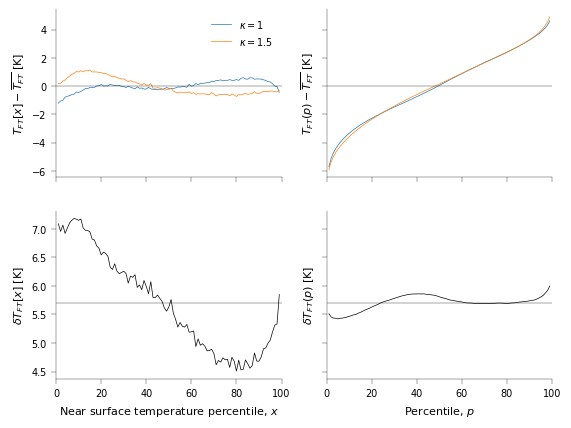

In [9]:
var_plot = 'temp_ft'
var_px_info = {'quant': {'temp_ft': temp_ft_quant, 'r': r_quant*100, 'epsilon': epsilon_quant},
               'quant3': {'temp_ft': temp_quant3[:, ind_ft], 'r': r_quant3*100, 'epsilon': epsilon_quant3},
               'av': {'temp_ft': temp_av[av_use][:, ind_ft], 'r': r_av[av_use] * 100, 'epsilon': epsilon_av[av_use]},
               'label': {'temp_ft': 'T_{FT}', 'r': 'r_s', 'epsilon': '\epsilon'},
               'unit': {'temp_ft': 'K', 'r': '%', 'epsilon': 'kJ/kg'}}

fig, ax = plt.subplots(2,2, figsize=(2*width['one_col'], 2*width['one_col']/ar), sharex=True, sharey='row')
for i in range(n_kappa):
    ax[0, 0].plot(quant_plot, np.average(var_px_info['quant3'][var_plot][i] - var_px_info['av'][var_plot][i, :, np.newaxis],
                                         weights=lat_weights, axis=0), color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax[0, 1].plot(quant_plot, np.average(var_px_info['quant'][var_plot][i] - var_px_info['av'][var_plot][i, :, np.newaxis],
                                         weights=lat_weights, axis=0), color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
ax[1, 0].plot(quant_plot, np.average(var_px_info['quant3'][var_plot][1]-var_px_info['quant3'][var_plot][0], weights=lat_weights, axis=0),
              color='k')
ax[1, 1].plot(quant_plot, np.average(var_px_info['quant'][var_plot][1]-var_px_info['quant'][var_plot][0], weights=lat_weights, axis=0), color='k')
ax[0, 0].legend()
ax[0, 0].set_xlim(0, 100)
for i in range(2):
    ax[0, i].axhline(0, color='k', lw=ax_linewidth)
    ax[1, i].axhline(np.average(var_px_info['av'][var_plot][1]-var_px_info['av'][var_plot][0], weights=lat_weights, axis=0), color='k', lw=ax_linewidth)
ax[1, 0].set_xlabel('Near surface temperature percentile, $x$')
ax[1, 1].set_xlabel('Percentile, $p$')
ax[0, 0].set_ylabel(f"${var_px_info['label'][var_plot]}[x] - \overline{'{'+var_px_info['label'][var_plot]+'}'}$ [{var_px_info['unit'][var_plot]}]")
ax[0, 1].set_ylabel(f"${var_px_info['label'][var_plot]}(p) - \overline{'{'+var_px_info['label'][var_plot]+'}'}$ [{var_px_info['unit'][var_plot]}]")
ax[1, 0].set_ylabel(f"$\delta {var_px_info['label'][var_plot]}[x]$ [{var_px_info['unit'][var_plot]}]")
ax[1, 1].set_ylabel(f"$\delta {var_px_info['label'][var_plot]}(p)$ [{var_px_info['unit'][var_plot]}]")
plt.show()

### Percentile, $p_x$, corresponding to $x$
Below I plot compute the variable, $\chi[x]$ averaged over all days with near-surface temperature percentile $x$.

I then, compute the percentile of $\chi$, $p_x$ such that the $p_x^{th}$ percentile of $\chi$ equals $\chi[x]$.
I.e. $p_x$ is defined such that $\chi(p_x) = \chi[x]$.

I plot $p_x$ vs $x$ below. Note, $x$ runs from 1 to 99 but $p_x$ does not have to fill all these values.

I do this for $\chi = T_{FT}, r, \epsilon$. Comparing to the above figures, it seems that most of the change with warming is due to a change in $p_x$.

In [10]:
p_x = {key: np.zeros((n_kappa, n_lat, n_quant)) for key in ['temp_ft', 'r', 'epsilon']}
p_x_av = {key: np.zeros((n_kappa, n_lat)) for key in ['temp_ft', 'r', 'epsilon']}
for key in p_x:
    for i in range(n_kappa):
        for j in range(n_lat):
            p_x[key][i, j] = get_p_x(var_px_info['quant3'][key][i, j], var_px_info['quant'][key][i, j], quant_plot)[0]
            p_x_av[key][i, j] = get_p_x(var_px_info['av'][key][i, j], var_px_info['quant'][key][i, j], quant_plot)[0]

In [11]:
key = 'r'
a = np.zeros((n_kappa, n_lat))
for i in range(n_kappa):
    for j in range(n_lat):
        a[i, j] = get_p_x(var_px_info['av'][key][i, j], var_px_info['quant'][key][i, j], quant_plot)[0]

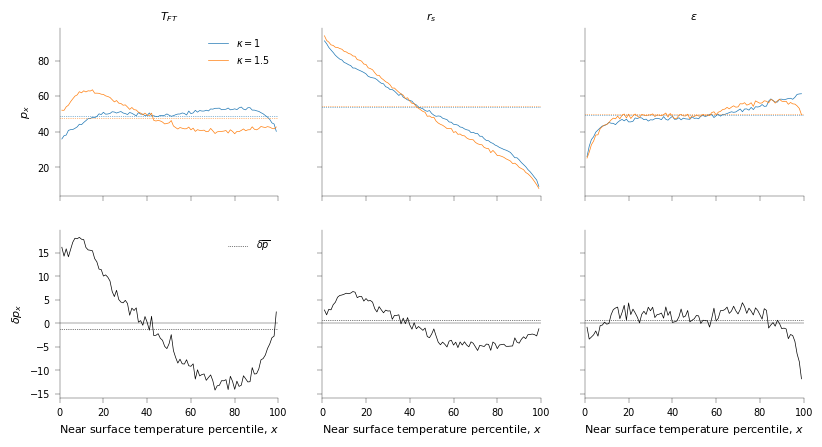

In [12]:
fig, ax = plt.subplots(2,len(p_x), figsize=(len(p_x)*width['one_col'], 2*width['one_col']/ar), sharex=True, sharey='row')
for j, key in enumerate(p_x):
    for i in range(n_kappa):
        ax[0, j].plot(quant_plot, np.average(p_x[key][i], axis=0, weights=lat_weights), label=f'$\kappa={tau_lw[i]}$')
        ax[0, j].axhline(np.average(p_x_av[key][i], axis=0, weights=lat_weights), color=default_colors[i], linestyle=':')
    ax[1, j].plot(quant_plot, np.average(p_x[key][1] - p_x[key][0], axis=0, weights=lat_weights), color='k')
    ax[1, j].axhline(np.average(p_x_av[key][1] - p_x_av[key][0], axis=0, weights=lat_weights), color='k', linestyle=':', label='$\delta \overline{p}$')
    ax[1, j].axhline(0, color='k', lw=ax_linewidth)
    ax[1, j].set_xlabel('Near surface temperature percentile, $x$')
    ax[0, j].set_title(f"${var_px_info['label'][key]}$")
ax[0, 0].legend()
ax[1, 0].legend()
ax[0, 0].set_xlim(0, 100)
ax[0, 0].set_ylabel('$p_x$')
ax[1, 0].set_ylabel('$\delta p_x$')
plt.show()

## Relating $\delta \chi[x]$ to $\delta \chi(p_x)$
We would first like to relate the change in a variable conditioned on the $x$ percenitle of near-surface temperature, $\delta \chi[c]$, to how the actual $\chi$ distribution changes if the correspondence between the two did not change with warming, $\delta \chi(p_x)$.

We have:

$\begin{align}
\delta \chi[x] &= \chi^{hot}(p_x + \delta p_x) - \chi^{cold}(p_x)\\
&= \delta \chi(p_x) + \int_{p_x}^{p_x + \delta p_x} \frac{\partial \chi^{hot}}{\partial p} dp\\
&= \delta \chi(p_x) + \int_{p_x}^{p_x + \delta p_x} \eta(p) + \delta \eta(p) dp\\
&\approx \delta \chi(p_x) + \eta(p_x)\delta p_x + \delta \eta(p_x)\delta p_x\\
&\approx \delta \chi(p_x) + \eta(p_x)\delta p_x
\end{align}$

where $\delta \chi(p_x) = \chi^{hot}(p_x) - \chi^{cold}(p_x)$ and $\eta = \frac{\partial \chi}{\partial p}$.

In [13]:
var_px_info['quant_px_cold'] = {key: np.zeros((n_kappa, n_lat, n_quant)) for key in p_x}
eta_px_cold = {key: np.zeros((n_kappa, n_lat, n_quant)) for key in p_x}
for key in p_x:
    px_cold_ind = np.round(p_x[key][0]).astype(int)-1      # -1 to give index as quant_plot[0]=1
    for i in range(n_kappa):
        for j in range(n_lat):
            # eta_mean[j] = np.polyfit(quant_plot[20:80], temp_ft_quant[0, j, 20:80], 1)[0]
            for q in range(n_quant):
                var_px_info['quant_px_cold'][key][i, j, q] = var_px_info['quant'][key][i, j, px_cold_ind[j, q]]
                eta_px_cold[key][i, j, q] = np.gradient(var_px_info['quant'][key][i, j], quant_plot)[px_cold_ind[j, q]]

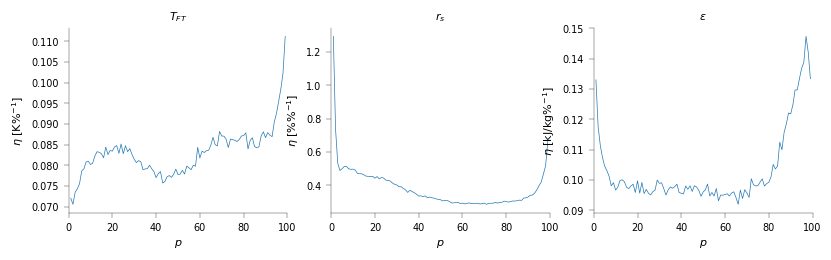

In [14]:
save_eta_fig = False
fig, ax = plt.subplots(1,len(p_x), figsize=(len(p_x)*width['one_col'], width['one_col']/ar), sharex=True)
for i, key in enumerate(p_x):
    ax[i].set_title(f"${var_px_info['label'][key]}$")
    ax[i].set_ylabel(f"$\eta$ [{var_px_info['unit'][key]}"+"%$^{-1}$]")
    ax[i].set_xlabel('$p$')
    ax[i].plot(quant_plot, np.average(eta_px_cold[key][0], axis=0, weights=lat_weights))
ax[0].set_xlim(0, 100)

if save_fig or save_eta_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/eta_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

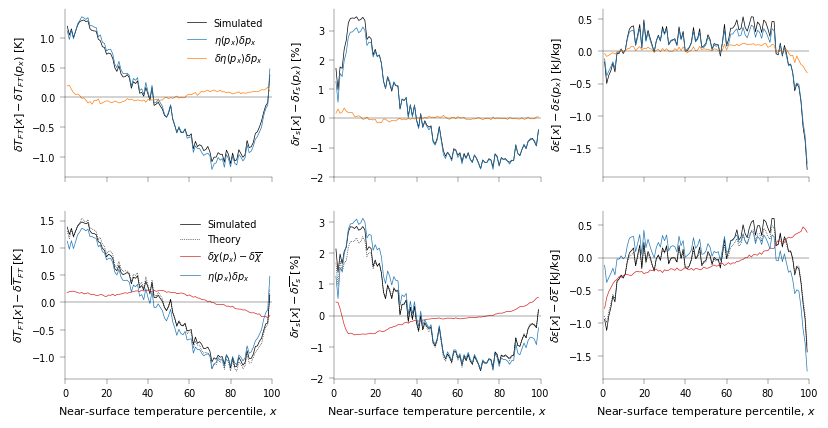

In [15]:
fig, ax = plt.subplots(2,len(p_x), figsize=(len(p_x)*width['one_col'], 2*width['one_col']/ar), sharex=True)
for i, key in enumerate(p_x):
    ax[0, i].plot(quant_plot, np.average((var_px_info['quant3'][key][1]-var_px_info['quant3'][key][0])  -
                                         (var_px_info['quant_px_cold'][key][1]-var_px_info['quant_px_cold'][key][0]), axis=0, weights=lat_weights),
                  color='k', label='Simulated')
    ax[0, i].plot(quant_plot, np.average(eta_px_cold[key][0] * (p_x[key][1]-p_x[key][0]), axis=0, weights=lat_weights), label='$\eta(p_x)\delta p_x$')
    ax[0, i].plot(quant_plot, np.average((eta_px_cold[key][1] - eta_px_cold[key][0]) * (p_x[key][1]-p_x[key][0]), axis=0, weights=lat_weights),
                  label='$\delta \eta(p_x) \delta p_x$')
    ax[0, i].axhline(0, color='k', lw=ax_linewidth)

    ax[1, i].plot(quant_plot, np.average(var_px_info['quant3'][key][1] - var_px_info['quant3'][key][0] -
                                         (var_px_info['av'][key][1] - var_px_info['av'][key][0])[:, np.newaxis], axis=0, weights=lat_weights),
               color='k', label='Simulated')
    ax[1, i].plot(quant_plot, np.average(var_px_info['quant_px_cold'][key][1] - var_px_info['quant_px_cold'][key][0] +
                                         eta_px_cold[key][0] * (p_x[key][1]-p_x[key][0]) -
                                         (var_px_info['av'][key][1] - var_px_info['av'][key][0])[:, np.newaxis], axis=0, weights=lat_weights),
                  color='k', label='Theory', linestyle=':')
    ax[1, i].plot(quant_plot, np.average(var_px_info['quant_px_cold'][key][1] - var_px_info['quant_px_cold'][key][0] -
                                         (var_px_info['av'][key][1] - var_px_info['av'][key][0])[:, np.newaxis], axis=0, weights=lat_weights),
                  color=default_colors[3], label='$\delta \chi(p_x) - \delta \overline{\chi}$')
    ax[1, i].plot(quant_plot, np.average(eta_px_cold[key][0] * (p_x[key][1]-p_x[key][0]), axis=0, weights=lat_weights),
                  color=default_colors[0], label='$\eta(p_x) \delta p_x$')
    ax[1, i].axhline(0, color='k', lw=ax_linewidth)

    ax[1, i].set_xlabel('Near-surface temperature percentile, $x$')
    ax[0, i].set_ylabel(f"$\delta {var_px_info['label'][key]}[x] - \delta {var_px_info['label'][key]}(p_x)$ [{var_px_info['unit'][key]}]")
    ax[1, i].set_ylabel(f"$\delta {var_px_info['label'][key]}[x] - \delta \overline{'{'+var_px_info['label'][key]+'}'}$ [{var_px_info['unit'][key]}]")
plt.subplots_adjust(wspace=0.3)
ax[0, 0].set_xlim(0, 100)
ax[0, 0].legend()
ax[1, 0].legend()
# ax[1].set_ylabel('$\delta (T_{FT}(x) - \overline{T_{FT}})$ [K]')
#
# ax[1].plot(quant_plot, np.average(temp_quant3[1, ind_ft] - temp_quant3[0, ind_ft] -
#                                   (temp_quant3[1, ind_ft] - temp_quant3[0, ind_ft])[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights),
#            color='k', label='Simulated')
# var = temp_ft_pxcold[1] - temp_ft_pxcold[0] + eta_pxcold[0] * (p_x[1]-p_x[0])
# ax[1].plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights), color='k', label='Theory', linestyle=':')
# var = temp_ft_pxcold[1] - temp_ft_pxcold[0]
# ax[1].plot(quant_plot, np.average(var - var[:, quant_median_ind, np.newaxis], axis=0, weights=lat_weights),
#            color=default_colors[3], label='$\delta T_{FT}[p_x]$')
# var = eta_pxcold[0] * (p_x[1]-p_x[0]) - (eta_pxcold[0] * (p_x[1]-p_x[0]))[:, quant_median_ind, np.newaxis]
# ax[1].plot(quant_plot, np.average(var, axis=0, weights=lat_weights), color=default_colors[0], label='$\eta[p_x]\delta p_x$')
# var = (eta_pxcold[1] - eta_pxcold[0]) * (p_x[1]-p_x[0])
# ax[1].legend()

### Isolating $x$ dependence of $\eta[p_x]$

Below I decompose this further to separate the $x$ dependence of $\delta p_x$ from $\eta(p_x)$.

The *theory* is given by $\delta \chi[x] = \delta \chi(p_x) + \overline{\eta_{\chi}} \delta p_x$. This does a good job, except for relative humidity at low quantiles, due to a large $\Delta \eta$ contribution.

In [16]:
var_px_anom_change_decomp = {key: {key2: np.zeros((n_lat, n_quant)) for key2 in p_x} for key in ['var_p', 'p_x', 'nl_eta0', 'nl_change',
                                                                                                 'approx_integral']}
var_px_anom_change_decomp['var_p']['label'] = '$\delta \chi(p_x) - \delta \overline{\chi}$'
var_px_anom_change_decomp['p_x']['label'] = '$\overline{\eta}\delta p_x$'
var_px_anom_change_decomp['nl_eta0']['label'] = '$\Delta \eta(p_x)\delta p_x$'
var_px_anom_change_decomp['nl_change']['label'] = '$\delta \eta(p_x)\delta p_x$'
var_px_anom_change_decomp['approx_integral']['label'] = 'Integral Approx'
for key in p_x:
    for j in range(n_lat):
        var_use = decompose_var_x_change_integrate(var_px_info['av'][key][:, j], var_px_info['quant3'][key][:, j],
                                                var_px_info['quant'][key][:, j], quant_plot, simple=False)[2]
        for key2 in var_use:
            var_px_anom_change_decomp[key2][key][j] = var_use[key2]
    # Take away average change from var_p component
    var_px_anom_change_decomp['var_p'][key] = var_px_anom_change_decomp['var_p'][key] \
                                              - (var_px_info['av'][key][1] - var_px_info['av'][key][0])[:, np.newaxis]

(0.0, 100.0)

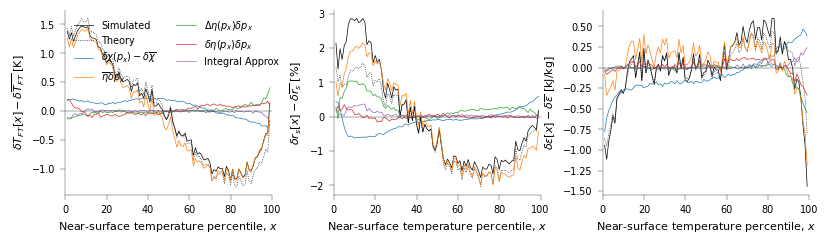

In [17]:
fig, ax = plt.subplots(1,len(p_x), figsize=(len(p_x) * width['one_col'], width['one_col']/ar), sharex=True)
for i, key in enumerate(p_x):
    ax[i].plot(quant_plot, np.average(var_px_info['quant3'][key][1] - var_px_info['quant3'][key][0] -
                                         (var_px_info['av'][key][1] - var_px_info['av'][key][0])[:, np.newaxis], axis=0, weights=lat_weights),
               color='k', label='Simulated')
    ax[i].plot(quant_plot, np.average(var_px_anom_change_decomp['var_p'][key]+var_px_anom_change_decomp['p_x'][key], axis=0, weights=lat_weights),
               color='k', linestyle=':', label='Theory')
    for key2 in var_px_anom_change_decomp:
        ax[i].plot(quant_plot, np.average(var_px_anom_change_decomp[key2][key], axis=0, weights=lat_weights),
               label=var_px_anom_change_decomp[key2]['label'])
    ax[i].set_ylabel(f"$\delta {var_px_info['label'][key]}[x] - \delta \overline{'{'+var_px_info['label'][key]+'}'}$ [{var_px_info['unit'][key]}]")
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    ax[i].set_xlabel('Near-surface temperature percentile, $x$')
plt.subplots_adjust(wspace=0.3)
ax[0].legend(ncol=2)
ax[0].set_xlim(0, 100)

### Reformulated Scale Factor
Using $\delta \chi[x] \approx \delta \chi(p_x) + \overline{\eta^{\chi}} \delta p^{\chi}_x$ for $\chi = T_{FT}, r_s, \epsilon$, the theory for the scale factor can be written as:

$$
\begin{align}
\frac{\delta \hat{T}_s(x)}{\delta \tilde{T}_s} &= \gamma_{\delta T_{FT}}\left[\frac{\delta T_{FT}(p_x^{T_{FT}})}{\delta \tilde{T}_s}
+ \overline{\eta^{T_{FT}}} \frac{\delta p^{T_{FT}}_x}{\delta \tilde{T}_s} \right]
- \gamma_{\delta r}\frac{\tilde{T}_s}{\tilde{r}_s} \left[\frac{\delta r_s(p_x^r)}{\delta \tilde{T}_s}
+ \overline{\eta^r} \frac{\delta p^r_x}{\delta \tilde{T}_s}\right]
+ \frac{\gamma_{\delta \epsilon}}{\tilde{\beta}_{s1}} \left[\frac{\delta \epsilon(p_x^{\epsilon})}{\delta \tilde{T}_s}
+ \overline{\eta^{\epsilon}} \frac{\delta p^{\epsilon}_x}{\delta \tilde{T}_s}\right] \\
&+ \gamma_{\Delta T_s} \frac{\Delta T_s(x)}{\tilde{T}_s}
- \gamma_{\Delta r} \frac{\Delta r[x]}{\tilde{r}_s}
- \gamma_{\Delta \epsilon} \frac{\Delta \epsilon[x]}{\tilde{\beta}_{s1} \tilde{T}_s}
- \gamma_{\delta \tilde{r}}\frac{\delta \tilde{r}_s}{\tilde{r}_s}
\end{align}
$$

The contribution of these different terms is shown below. The approximation is worse in this form because of the neglection of important non-linear terms (especially for aquaplanet), but the conclusion that the change in $p_x$ of the different variables is the major cause in the variation with $x$ of each of the $\delta \chi[x]$ terms is valid. The decomposition is mainly useful in pointing this out.

In [18]:
sf_simulated = np.diff(temp_quant3[:, ind_surf], axis=0).squeeze()/np.diff(temp_ref[:, ind_surf], axis=0).squeeze()[:, np.newaxis]
sf_theory = {key: np.zeros((n_lat, n_quant)) for key in ['std', 'p_x']}
sf_theory_cont = {'std':{key: np.zeros((n_lat, n_quant)) for key in
                         ['temp_ft_change', 'r_change', 'epsilon_change', 'temp_anom', 'r_anom', 'epsilon_anom']}}
gamma_factors = {key: np.zeros(n_lat) for key in sf_theory_cont['std']}
if use_av_as_ref:
    sf_theory_cont['std']['r_ref_change'] = np.zeros(n_lat)
var_use = [0, 0]
for i in range(n_lat):
    sf_theory['std'][i], var_use[0], _, var_use[1] = get_scale_factor_theory(temp_ref[:, ind_surf, i], temp_quant3[:, ind_surf, i], r_ref[:, i],
                                                                             r_quant3[:, i], temp_quant3[:, ind_ft, i], epsilon_quant3[:, i], p_surface,
                                                                             pressure_ft_actual, epsilon_ref[:, i], z_approx_error_ref[:, i])
    for key in sf_theory_cont['std']:
        sf_theory_cont['std'][key][i] = var_use[1][key]
        gamma_factors[key][i] = var_use[0][key]

In [19]:
beta_s1 = get_theory_prefactor_terms(temp_ref[:, ind_surf], p_surface, pressure_ft_actual, sphum_ref)[3]
sf_theory_cont['p_x'] = {key: sf_theory_cont['std'][key] for key in ['temp_anom', 'r_anom', 'epsilon_anom']}
if use_av_as_ref:
    sf_theory_cont['p_x']['r_ref_change'] = sf_theory_cont['std']['r_ref_change']
for key in ['temp_ft', 'r', 'epsilon']:
    sf_theory_cont['p_x'][key+'_change'] = gamma_factors[key+'_change'][:, np.newaxis] * (
            var_px_info['quant_px_cold'][key][1] - var_px_info['quant_px_cold'][key][0])
    sf_theory_cont['p_x'][key+'_p_change'] = gamma_factors[key+'_change'][:, np.newaxis] * var_px_anom_change_decomp['p_x'][key]

# Account for prefactor terms and sign, required so gamma dimensionless
for key in ['_change', '_p_change']:
    sf_theory_cont['p_x']['temp_ft'+key] /= np.diff(temp_ref[:, ind_surf], axis=0).squeeze()[:, np.newaxis]
    sf_theory_cont['p_x']['r'+key] = -sf_theory_cont['p_x']['r'+key]/(100 * r_ref[0, :, np.newaxis]) * (
            temp_ref[0, ind_surf]/np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis]
    sf_theory_cont['p_x']['epsilon'+key] = sf_theory_cont['p_x']['epsilon'+key]*1000 / (
            beta_s1[0] * np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis]
sf_theory['p_x'] = sum(sf_theory_cont['p_x'].values())

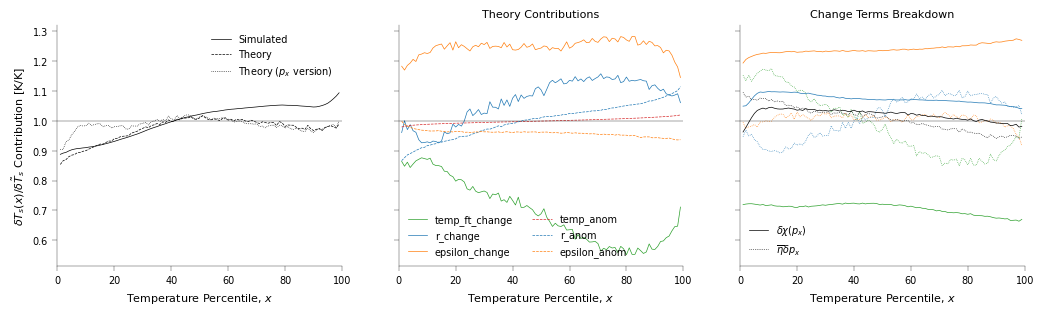

In [20]:
colors_cont = {'temp_ft_change': default_colors[2],'temp_ft_p_change': default_colors[2],
               'temp_anom': default_colors[3], 'r_anom': default_colors[0],
               'r_change': default_colors[0], 'r_p_change': default_colors[0],
               'epsilon_anom': default_colors[1],
               'epsilon_change': default_colors[1], 'epsilon_p_change': default_colors[1], 'r_ref_change': default_colors[4]}
linestyle_cont = {key: None for key in colors_cont}
for key in linestyle_cont:
    if 'p_change' in key:
        linestyle_cont[key] = ':'
    elif 'change' not in key:
        linestyle_cont[key] = '--'

fig, ax = plt.subplots(1,3, figsize=(1.3*3*width['one_col'], 1.3*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(quant_plot, np.average(sf_simulated, axis=0, weights=lat_weights), color='k', label='Simulated')
ax[0].plot(quant_plot, np.average(sf_theory['std'], axis=0, weights=lat_weights), color='k', linestyle=linestyle_cont['r_anom'], label='Theory')
ax[0].plot(quant_plot, np.average(sf_theory['p_x'], axis=0, weights=lat_weights), color='k', linestyle=linestyle_cont['r_p_change'],
           label='Theory ($p_x$ version)')

for key in sf_theory_cont['std']:
    if (not use_av_as_ref) and (key == 'r_ref_change'):
        continue
    ax[1].plot(quant_plot, (0 if key=='temp_ft_change' else 1) + np.average(sf_theory_cont['std'][key], axis=0, weights=lat_weights),
               label=key, linestyle=linestyle_cont[key], color=colors_cont[key])
for key in sf_theory_cont['p_x']:
    if 'change' not in key:
        continue
    if (not use_av_as_ref) and (key == 'r_ref_change'):
        continue
    ax[2].plot(quant_plot, (0 if key=='temp_ft_change' else 1) + np.average(sf_theory_cont['p_x'][key], axis=0, weights=lat_weights),
               linestyle=linestyle_cont[key], color=colors_cont[key])

ax[2].plot(quant_plot, np.average(sf_theory_cont['p_x']['temp_ft_change']+sf_theory_cont['p_x']['r_change']+
                                      sf_theory_cont['p_x']['epsilon_change'], axis=0, weights=lat_weights),
           color='k', linestyle=linestyle_cont['r_change'], label='$\delta \chi(p_x)$')
ax[2].plot(quant_plot, 1 + np.average(sf_theory_cont['p_x']['temp_ft_p_change']+sf_theory_cont['p_x']['r_p_change']+
                                      sf_theory_cont['p_x']['epsilon_p_change'], axis=0, weights=lat_weights),
           color='k', linestyle=linestyle_cont['r_p_change'], label='$\overline{\eta} \delta p_x$')

for i, ax_use in enumerate(ax):
    ax_use.legend(ncol=2 if i==1 else 1)
    ax_use.axhline(1, color='k', lw=ax_linewidth)
    ax_use.set_xlabel('Temperature Percentile, $x$')
ax[0].set_xlim(0, 100)
ax[1].set_title('Theory Contributions')
ax[2].set_title('Change Terms Breakdown')
ax[0].set_ylabel('$\delta T_s(x)/\delta \\tilde{T}_s$ Contribution [K/K]')
# ax[2].set_ylim(0.8, 1.3)
# if use_av_as_ref:
#     ax[0].set_ylim(0.8, 1.2)
# else:
#     ax[0].set_ylim(0.55, 1.3)
plt.show()

### Neglecting integral approximation

If we don't do an integral, we have:

$\begin{align}
\delta \chi[x] &= \chi^{hot}(p_x + \delta p_x) - \chi^{cold}(p_x)\\
&= \delta \chi(p_x) + [\chi(p_x+\delta p_x) - \chi(p_x)] + [\delta \chi(p_x+\delta p_x) - \delta \chi(p_x)]
\end{align}$

The first term quantifies the change due to change in distribution of $\chi$ with warming. The second term quantifies the effect of change in percentile with warming, assuming no change in distribution. The third is a non-linear combination of these effects.

I think this version is more accurate, and easier to explain.

#### Reformulated Scale Factor
Using $\delta \chi[x] \approx \delta \chi(p_x) + [\chi(p_x+\delta p_x) - \chi(p_x)]$ for $\chi = T_{FT}, r_s, \epsilon$, the theory for the scale factor can be written as:

$$
\begin{align}
\frac{\delta \hat{T}_s(x)}{\delta \tilde{T}_s} &= \gamma_{\delta T_{FT}}\left[\frac{\delta T_{FT}(p_x^{T_{FT}})}{\delta \tilde{T}_s}
+ \frac{T_{FT}(p_x^{T_{FT}} + \delta p_x^{T_{FT}}) - T_{FT}(p_x^{T_{FT}})}{\delta \tilde{T}_s} \right]
- \gamma_{\delta r}\frac{\tilde{T}_s}{\tilde{r}_s} \left[\frac{\delta r_s(p_x^r)}{\delta \tilde{T}_s}
+ \frac{r(p_x^r + \delta p_x^r) - r(p_x^r)}{\delta \tilde{T}_s}\right]
+ \frac{\gamma_{\delta \epsilon}}{\tilde{\beta}_{s1}} \left[\frac{\delta \epsilon(p_x^{\epsilon})}{\delta \tilde{T}_s}
+ \frac{\epsilon(p_x^{\epsilon} + \delta p_x^{\epsilon}) - \epsilon(p_x^{\epsilon})}{\delta \tilde{T}_s}\right] \\
&+ \gamma_{\Delta T_s} \frac{\Delta T_s(x)}{\tilde{T}_s}
- \gamma_{\Delta r} \frac{\Delta r[x]}{\tilde{r}_s}
- \gamma_{\Delta \epsilon} \frac{\Delta \epsilon[x]}{\tilde{\beta}_{s1} \tilde{T}_s}
- \gamma_{\delta \tilde{r}}\frac{\delta \tilde{r}_s}{\tilde{r}_s}
\end{align}
$$

In [21]:
var_px_anom_change_decomp2 = {key: {key2: np.zeros((n_lat, n_quant)) for key2 in p_x} for key in ['dist', 'p_x', 'nl', 'residual']}
var_px_anom_change_decomp2['dist']['label'] = '$\delta \chi(p_x) - \delta \overline{\chi}$'
var_px_anom_change_decomp2['p_x']['label'] = '$\chi(p_x+\delta p_x) - \chi(p_x)$'
var_px_anom_change_decomp2['nl']['label'] = '$\delta \chi(p_x+\delta p_x) - \delta \chi(p_x)$'

for key in p_x:
    for j in range(n_lat):
        var_use = decompose_var_x_change(var_px_info['quant3'][key][:, j],
                                         var_px_info['quant'][key][:, j], quant_plot, simple=False)[2]
        for key2 in var_use:
            var_px_anom_change_decomp2[key2][key][j] = var_use[key2]
    # use residual as a sanity check - should be zero
    var_px_anom_change_decomp2['residual'][key] = var_px_info['quant3'][key][1] - var_px_info['quant3'][key][0] - \
        var_px_anom_change_decomp2['dist'][key] - var_px_anom_change_decomp2['p_x'][key] - var_px_anom_change_decomp2['nl'][key]
    # Take away average change from var_p component
    var_px_anom_change_decomp2['dist'][key] = var_px_anom_change_decomp2['dist'][key] \
                                              - (var_px_info['av'][key][1] - var_px_info['av'][key][0])[:, np.newaxis]

for key in var_px_anom_change_decomp2['residual']:
    print("{} residual: {:.2g}".format(key, np.abs(var_px_anom_change_decomp2['residual'][key]).max()))

temp_ft residual: 0
r residual: 0
epsilon residual: 4.4e-16


(0.0, 100.0)

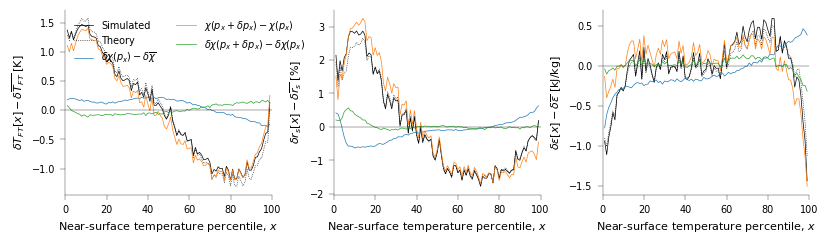

In [22]:
fig, ax = plt.subplots(1,len(p_x), figsize=(len(p_x) * width['one_col'], width['one_col']/ar), sharex=True)
for i, key in enumerate(p_x):
    ax[i].plot(quant_plot, np.average(var_px_info['quant3'][key][1] - var_px_info['quant3'][key][0] -
                                         (var_px_info['av'][key][1] - var_px_info['av'][key][0])[:, np.newaxis], axis=0, weights=lat_weights),
               color='k', label='Simulated')
    ax[i].plot(quant_plot, np.average(var_px_anom_change_decomp2['dist'][key]+var_px_anom_change_decomp2['p_x'][key], axis=0, weights=lat_weights),
               color='k', linestyle=':', label='Theory')
    for key2 in var_px_anom_change_decomp2:
        if key2 == 'residual':
            continue
        ax[i].plot(quant_plot, np.average(var_px_anom_change_decomp2[key2][key], axis=0, weights=lat_weights),
               label=var_px_anom_change_decomp2[key2]['label'])
    ax[i].set_ylabel(f"$\delta {var_px_info['label'][key]}[x] - \delta \overline{'{'+var_px_info['label'][key]+'}'}$ [{var_px_info['unit'][key]}]")
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    ax[i].set_xlabel('Near-surface temperature percentile, $x$')
plt.subplots_adjust(wspace=0.3)
ax[0].legend(ncol=2)
ax[0].set_xlim(0, 100)

In [23]:
beta_s1 = get_theory_prefactor_terms(temp_ref[:, ind_surf], p_surface, pressure_ft_actual, sphum_ref)[3]
sf_theory_cont['p_x2'] = {key: sf_theory_cont['std'][key] for key in ['temp_anom', 'r_anom', 'epsilon_anom']}
if use_av_as_ref:
    sf_theory_cont['p_x2']['r_ref_change'] = sf_theory_cont['std']['r_ref_change']
for key in ['temp_ft', 'r', 'epsilon']:
    sf_theory_cont['p_x2'][key+'_change'] = gamma_factors[key+'_change'][:, np.newaxis] * (
            var_px_anom_change_decomp2['dist'][key] + (var_px_info['av'][key][1] - var_px_info['av'][key][0])[:, np.newaxis])
    sf_theory_cont['p_x2'][key+'_p_change'] = gamma_factors[key+'_change'][:, np.newaxis] * var_px_anom_change_decomp2['p_x'][key]

# Account for prefactor terms and sign, required so gamma dimensionless
for key in ['_change', '_p_change']:
    sf_theory_cont['p_x2']['temp_ft'+key] /= np.diff(temp_ref[:, ind_surf], axis=0).squeeze()[:, np.newaxis]
    sf_theory_cont['p_x2']['r'+key] = -sf_theory_cont['p_x2']['r'+key]/(100 * r_ref[0, :, np.newaxis]) * (
            temp_ref[0, ind_surf]/np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis]
    sf_theory_cont['p_x2']['epsilon'+key] = sf_theory_cont['p_x2']['epsilon'+key]*1000 / (
            beta_s1[0] * np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis]

sf_theory['p_x2'] = sum(sf_theory_cont['p_x2'].values())

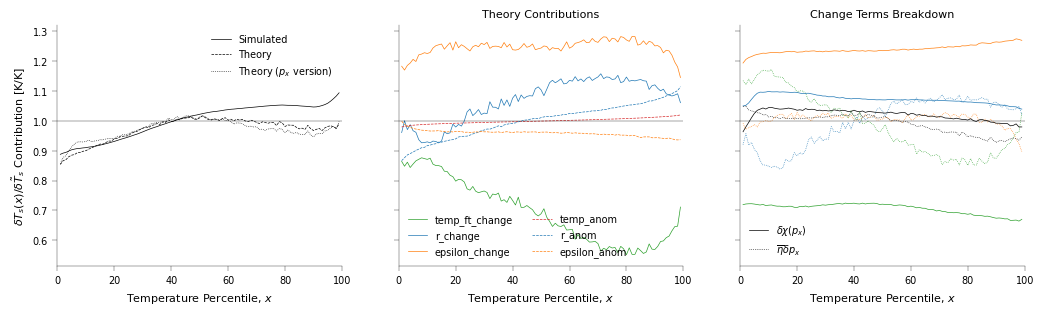

In [24]:
fig, ax = plt.subplots(1,3, figsize=(1.3*3*width['one_col'], 1.3*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(quant_plot, np.average(sf_simulated, axis=0, weights=lat_weights), color='k', label='Simulated')
ax[0].plot(quant_plot, np.average(sf_theory['std'], axis=0, weights=lat_weights), color='k', linestyle=linestyle_cont['r_anom'], label='Theory')
ax[0].plot(quant_plot, np.average(sf_theory['p_x2'], axis=0, weights=lat_weights), color='k', linestyle=linestyle_cont['r_p_change'],
           label='Theory ($p_x$ version)')

for key in sf_theory_cont['std']:
    if (not use_av_as_ref) and (key == 'r_ref_change'):
        continue
    ax[1].plot(quant_plot, (0 if key=='temp_ft_change' else 1) + np.average(sf_theory_cont['std'][key], axis=0, weights=lat_weights),
               label=key, linestyle=linestyle_cont[key], color=colors_cont[key])
for key in sf_theory_cont['p_x2']:
    if 'change' not in key:
        continue
    if (not use_av_as_ref) and (key == 'r_ref_change'):
        continue
    ax[2].plot(quant_plot, (0 if key=='temp_ft_change' else 1) + np.average(sf_theory_cont['p_x2'][key], axis=0, weights=lat_weights),
               linestyle=linestyle_cont[key], color=colors_cont[key])

ax[2].plot(quant_plot, np.average(sf_theory_cont['p_x2']['temp_ft_change']+sf_theory_cont['p_x2']['r_change']+
                                      sf_theory_cont['p_x2']['epsilon_change'], axis=0, weights=lat_weights),
           color='k', linestyle=linestyle_cont['r_change'], label='$\delta \chi(p_x)$')
ax[2].plot(quant_plot, 1 + np.average(sf_theory_cont['p_x2']['temp_ft_p_change']+sf_theory_cont['p_x2']['r_p_change']+
                                      sf_theory_cont['p_x2']['epsilon_p_change'], axis=0, weights=lat_weights),
           color='k', linestyle=linestyle_cont['r_p_change'], label='$\delta p_x$')

for i, ax_use in enumerate(ax):
    ax_use.legend(ncol=2 if i==1 else 1)
    ax_use.axhline(1, color='k', lw=ax_linewidth)
    ax_use.set_xlabel('Temperature Percentile, $x$')
ax[0].set_xlim(0, 100)
ax[1].set_title('Theory Contributions')
ax[2].set_title('Change Terms Breakdown')
ax[0].set_ylabel('$\delta T_s(x)/\delta \\tilde{T}_s$ Contribution [K/K]')
# ax[2].set_ylim(0.8, 1.3)
# if use_av_as_ref:
#     ax[0].set_ylim(0.8, 1.2)
# else:
#     ax[0].set_ylim(0.55, 1.3)
plt.show()